## **Importing libraries and datasets**

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


In [ ]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [ ]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [ ]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [ ]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [ ]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [ ]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [ ]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857


In [ ]:
df_trans_3m = df_transactions[df_transactions['trans_date'] > '2014-12-01']

df_rfm_3m = df_trans_3m.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm_3m.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

df_rfm_3m.head()

,recency,frequency,monetary_value
customer_id,,,
CS1112,62.0,2,98
CS1113,36.0,3,220
CS1114,33.0,3,211
CS1115,12.0,1,55
CS1118,3.0,2,114


In [ ]:
df_rfm_3m = df_rfm_3m.reset_index()
df_rfm_3m.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,2,98
1,CS1113,36.0,3,220
2,CS1114,33.0,3,211
3,CS1115,12.0,1,55
4,CS1118,3.0,2,114


In [ ]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

df_clv.head()

,recency,frequency,monetary_value,AOU,ticket_size
customer_id,,,,,
CS1112,62.0,15,1012,1309,67.466667
CS1113,36.0,20,1490,1354,74.500000
CS1114,33.0,19,1432,1309,75.368421
CS1115,12.0,22,1659,1303,75.409091
CS1116,204.0,13,857,1155,65.923077


In [ ]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,15,1012,1309,67.466667
1,CS1113,36.0,20,1490,1354,74.500000
2,CS1114,33.0,19,1432,1309,75.368421
3,CS1115,12.0,22,1659,1303,75.409091
4,CS1116,204.0,13,857,1155,65.923077


In [ ]:
df_trans_3m = df_transactions[df_transactions['trans_date'] > '2014-12-01']

df_clv_3m = df_trans_3m.groupby('customer_id').agg(recency3m=('recent',min),                      # Recency
                                                     freq3m=('trans_date',pd.Series.nunique),                 # Frequency
                                                     monetary_value3m = ('tran_amount' ,np.sum), # Monetary Value
                                                     ticket_size3m = ('tran_amount' ,np.mean),
                                                     amount_var3m = ('tran_amount' ,np.std),
                                                     amount_med3m = ('tran_amount' ,np.median),
                                                     AOU3m = ('trans_date' ,lambda x: (x.max() - x.min()).days)
                                                     )                          



df_clv_3m.head()

,recency3m,freq3m,monetary_value3m,ticket_size3m,amount_var3m,amount_med3m,AOU3m
customer_id,,,,,,,
CS1112,62.0,2,98,49.000000,14.142136,49.0,41
CS1113,36.0,2,220,73.333333,27.300794,78.0,26
CS1114,33.0,3,211,70.333333,29.955523,79.0,62
CS1115,12.0,1,55,55.000000,NaN,55.0,0
CS1118,3.0,2,114,57.000000,4.242641,57.0,96


In [ ]:
df_clv_3m = df_clv_3m.reset_index()
df_clv_3m.head()

,customer_id,recency3m,freq3m,monetary_value3m,ticket_size3m,amount_var3m,amount_med3m,AOU3m
0,CS1112,62.0,2,98,49.000000,14.142136,49.0,41
1,CS1113,36.0,2,220,73.333333,27.300794,78.0,26
2,CS1114,33.0,3,211,70.333333,29.955523,79.0,62
3,CS1115,12.0,1,55,55.000000,NaN,55.0,0
4,CS1118,3.0,2,114,57.000000,4.242641,57.0,96


## **Calculating response rate**

In [ ]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


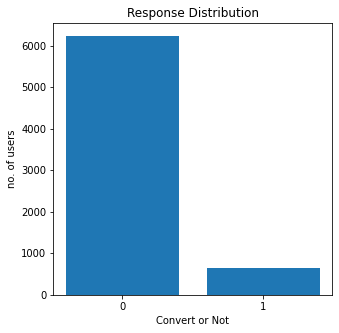

In [ ]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [ ]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm_3m)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,2,98
1,CS1113,0,36.0,3,220
2,CS1114,1,33.0,3,211
3,CS1115,1,12.0,1,55
4,CS1118,1,3.0,2,114


In [ ]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv_3m)
df_modeling_clv.head()

,customer_id,response,recency3m,freq3m,monetary_value3m,ticket_size3m,amount_var3m,amount_med3m,AOU3m
0,CS1112,0,62.0,2,98,49.000000,14.142136,49.0,41
1,CS1113,0,36.0,2,220,73.333333,27.300794,78.0,26
2,CS1114,1,33.0,3,211,70.333333,29.955523,79.0,62
3,CS1115,1,12.0,1,55,55.000000,NaN,55.0,0
4,CS1118,1,3.0,2,114,57.000000,4.242641,57.0,96


## **Creating train and test dataset**

In [ ]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [ ]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

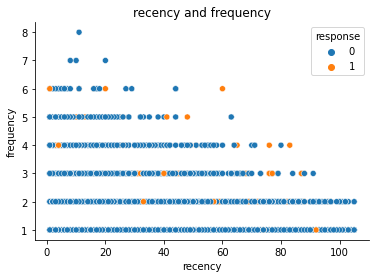

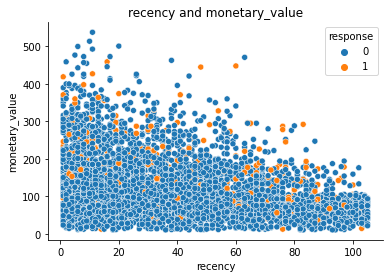

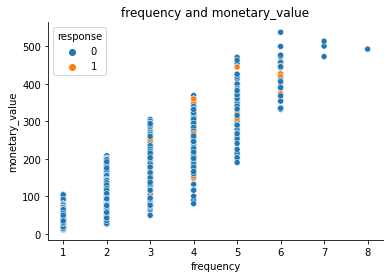

In [ ]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

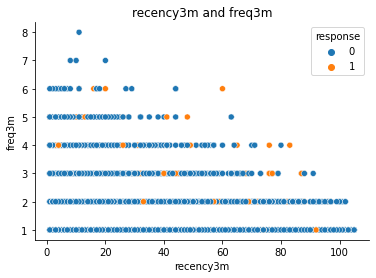

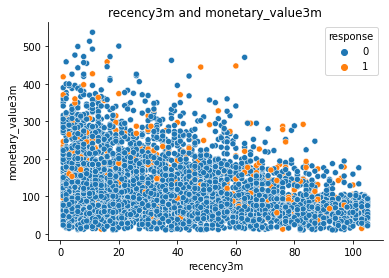

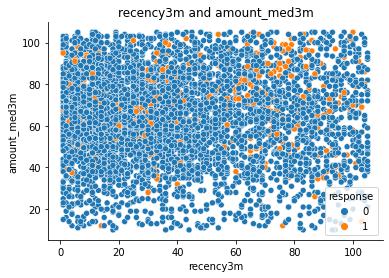

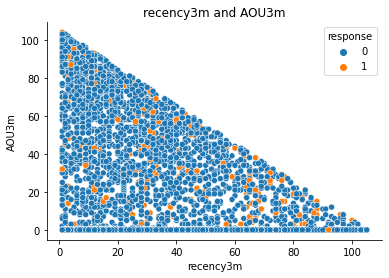

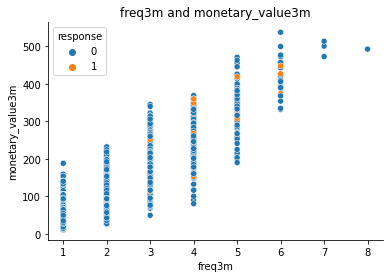

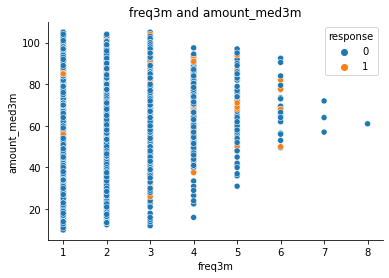

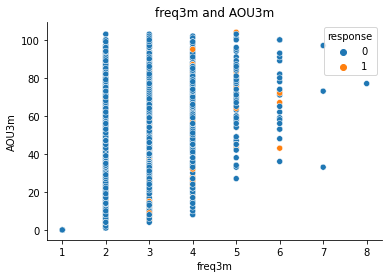

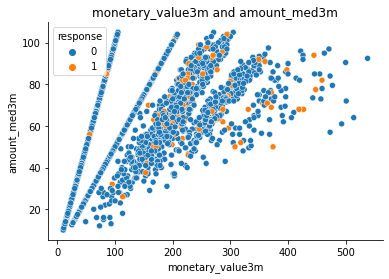

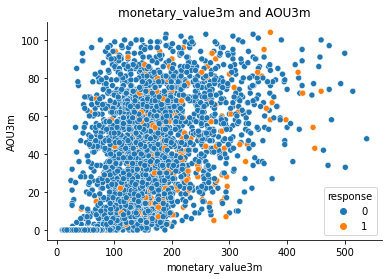

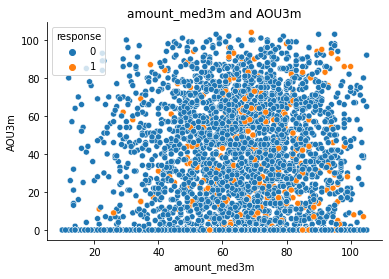

In [ ]:
#'recency3m', 'freq3m', 'monetary_value3m', 'ticket_size3m', 'amount_var3m', 'amount_med3m', 'AOU3m'

for i, col_i in enumerate(df_modeling_clv[['recency3m', 'freq3m', 'monetary_value3m', 'amount_med3m', 'AOU3m']].columns):
  for j, col_j in enumerate(df_modeling_clv[[ 'recency3m', 'freq3m', 'monetary_value3m','amount_med3m', 'AOU3m']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [ ]:
## spliting dataframe into X and y

df_X = df_modeling_clv.drop(columns=['response','customer_id']).fillna(0)
df_y = df_modeling_clv['response'].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y , test_size=0.3, random_state=0)



sm = SMOTE(random_state=1234)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train )

print("before smote :",sum(y_train) ," total data" ,len(y_train))
print("after smote :",sum(y_SMOTE) ," total data" ,len(y_SMOTE))

before smote : 312  total data 3509
after smote : 3197  total data 6394


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Logistic Regression**

In [ ]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.61      0.59      0.60      3197
           1       0.60      0.62      0.61      3197

    accuracy                           0.61      6394
   macro avg       0.61      0.61      0.61      6394
weighted avg       0.61      0.61      0.61      6394

test set
              precision    recall  f1-score   support

           0       0.94      0.60      0.73      1379
           1       0.12      0.61      0.20       125

    accuracy                           0.60      1504
   macro avg       0.53      0.60      0.47      1504
weighted avg       0.88      0.60      0.69      1504



## **XGBoost**

In [ ]:
print('XGBoost model - SMOTE')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE
[0]	validation_0-auc:0.617572
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.610744
[2]	validation_0-auc:0.621175
[3]	validation_0-auc:0.619782
[4]	validation_0-auc:0.619782
[5]	validation_0-auc:0.618773
[6]	validation_0-auc:0.633082
[7]	validation_0-auc:0.631168
[8]	validation_0-auc:0.636203
[9]	validation_0-auc:0.635739
[10]	validation_0-auc:0.637932
[11]	validation_0-auc:0.638332
[12]	validation_0-auc:0.638547
[13]	validation_0-auc:0.63933
[14]	validation_0-auc:0.640264
[15]	validation_0-auc:0.63781
[16]	validation_0-auc:0.638193
[17]	validation_0-auc:0.635228
[18]	validation_0-auc:0.635228
[19]	validation_0-auc:0.634776
Stopping. Best iteration:
[14]	validation_0-auc:0.640264

training set
              precision    recall  f1-score   support

           0       0.65      0.61      0.63      3197
           1       0.63      0.67      0.65      3197

    accuracy                           0.64      6394
   macro avg      

In [ ]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [ ]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=42)
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.2min finished


In [ ]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print(confusion_matrix(y_test,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.63079676382098
[[994 385]
 [ 65  60]]
test set
              precision    recall  f1-score   support

           0       0.94      0.72      0.82      1379
           1       0.13      0.48      0.21       125

    accuracy                           0.70      1504
   macro avg       0.54      0.60      0.51      1504
weighted avg       0.87      0.70      0.77      1504



In [ ]:
print(xgb_model_clv_GS.best_params_)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 300, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7f8573646cb0>}


In [ ]:
auc_train = roc_auc_score(y_train, xgb_model_clv_GS.predict_proba(X_train)[:, 1])
auc_test =  roc_auc_score(y_test, xgb_model_clv_GS.predict_proba(X_test)[:, 1])
print(auc_train)
print(auc_test)

0.6856929172381159
0.6425090645395214
